In [1]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Camera calibration

images_names = glob.glob('./camera_cal/calibration*.jpg')

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D piints in image plane

objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2) # x, y coordinates

for fname in images_names:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

def undistroted(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

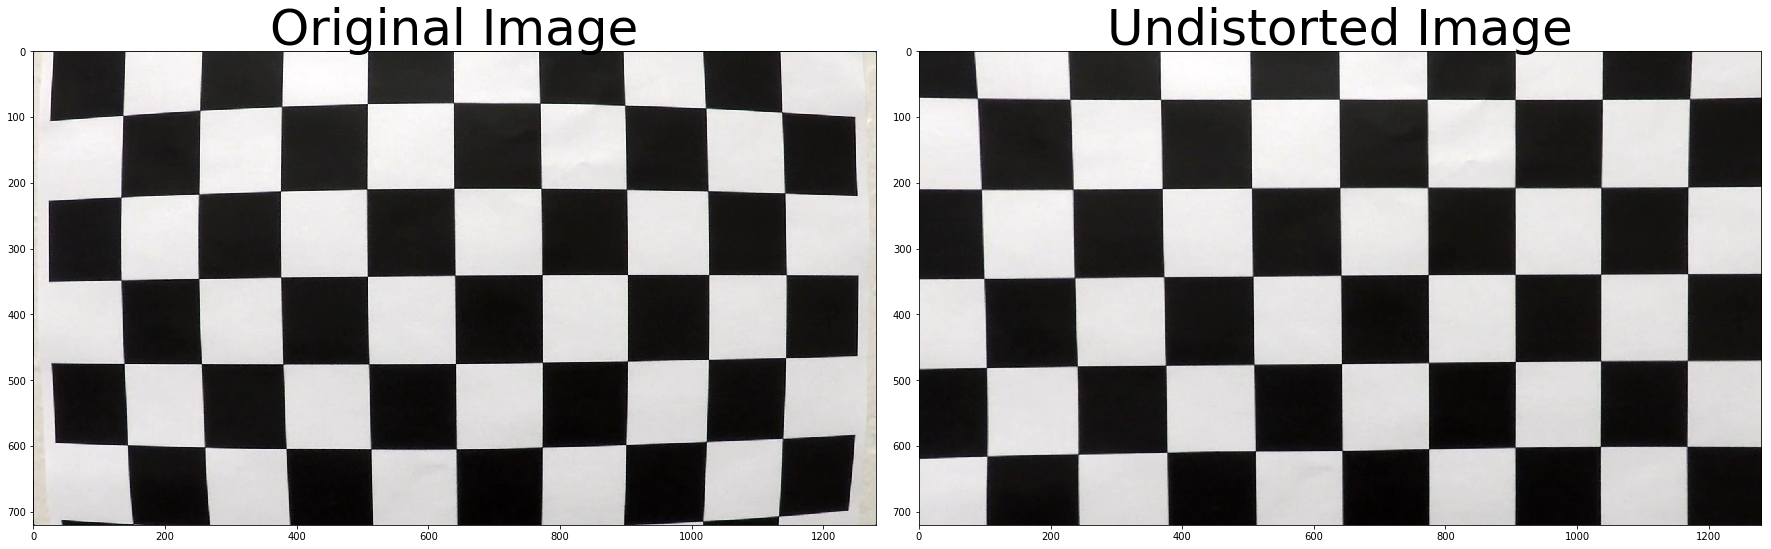

In [3]:
img = mpimg.imread('./camera_cal/calibration1.jpg')

img_undistroted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undistroted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

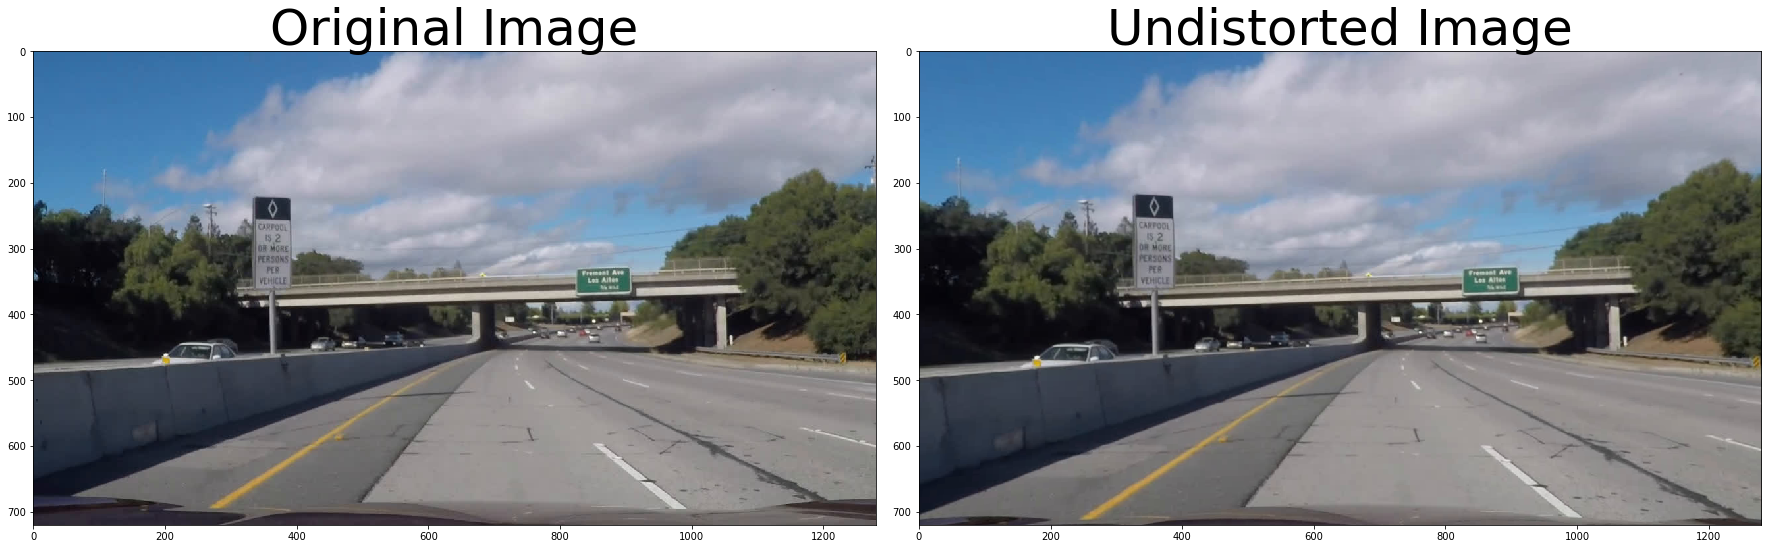

In [4]:
img = mpimg.imread('./test_images/challenge01.jpg')

img_undistroted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undistroted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(abs_sobel * 255 / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    mag = np.uint8(mag * 255 / np.max(mag))
    mag_binary = np.zeros_like(mag)
    mag_binary[(mag >= mag_thresh[0]) & (mag <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return dir_binary

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = HLS[:,:,2]
    L = HLS[:,:,1]
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(L)
    binary_output[(L > thresh[0]) & (L <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary_output

def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    #if np.max(lab_b) > 175:
    #    lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def combined_binary(image):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(15, 150))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3)) #np.pi/3

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) | (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    gradient_binary = combined
    
    hls_binary = hls_select(image, thresh=(170, 255))
    lab_binary = lab_bthresh(image, thresh=(133, 255))
    
    combined_binary = np.zeros_like(hls_binary)
    combined_binary[(hls_binary == 1) | (lab_binary == 1)] = 1
    return combined_binary

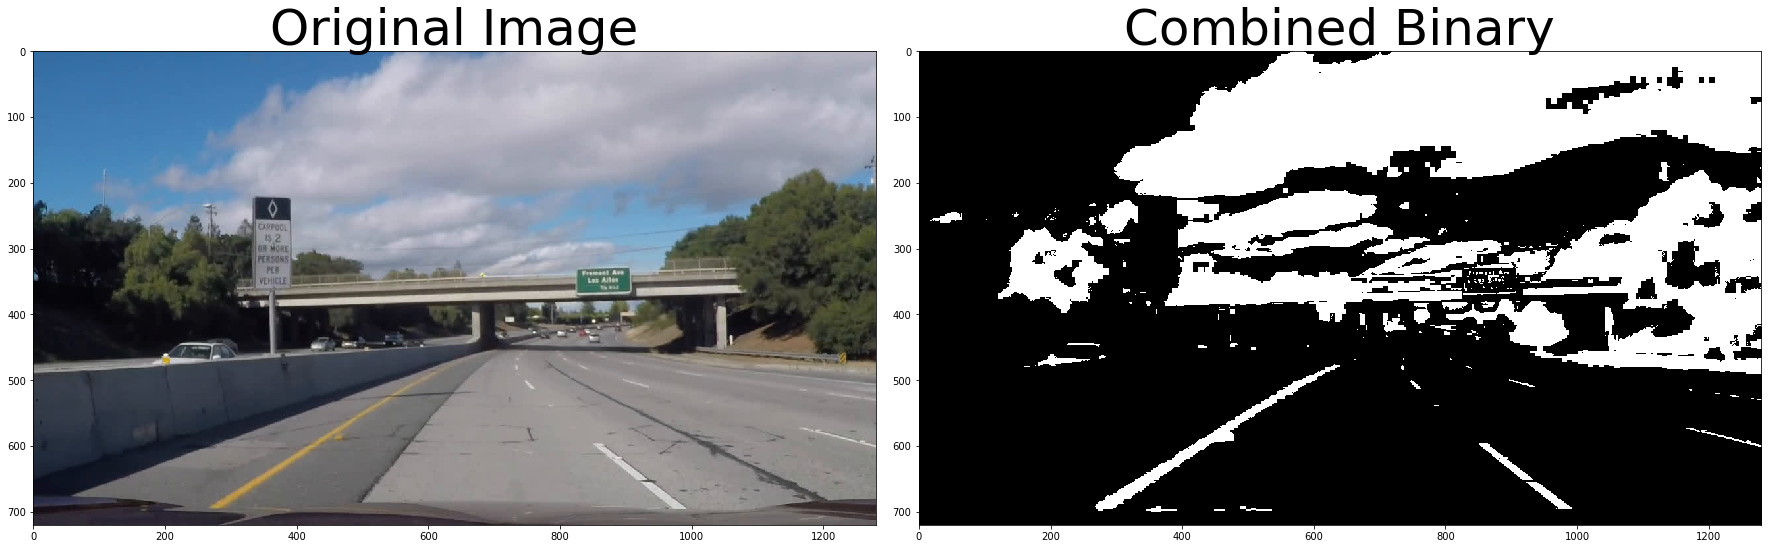

In [6]:
img = mpimg.imread('./test_images/challenge01.jpg')

img_combined_binary = combined_binary(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_combined_binary, 'gray')
ax2.set_title('Combined Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [7]:
def warpPerspective_from_img(image):
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    img_size = (gray.shape[1],gray.shape[0])

    src = np.float32(
        [[(img_size[0] / 2) - 58, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 0), img_size[1]-10],
        [(img_size[0] * 5 / 6) + 48, img_size[1]-10],
        [(img_size[0] / 2 + 64), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    #Minv = np.linalg.inv(M)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR), Minv

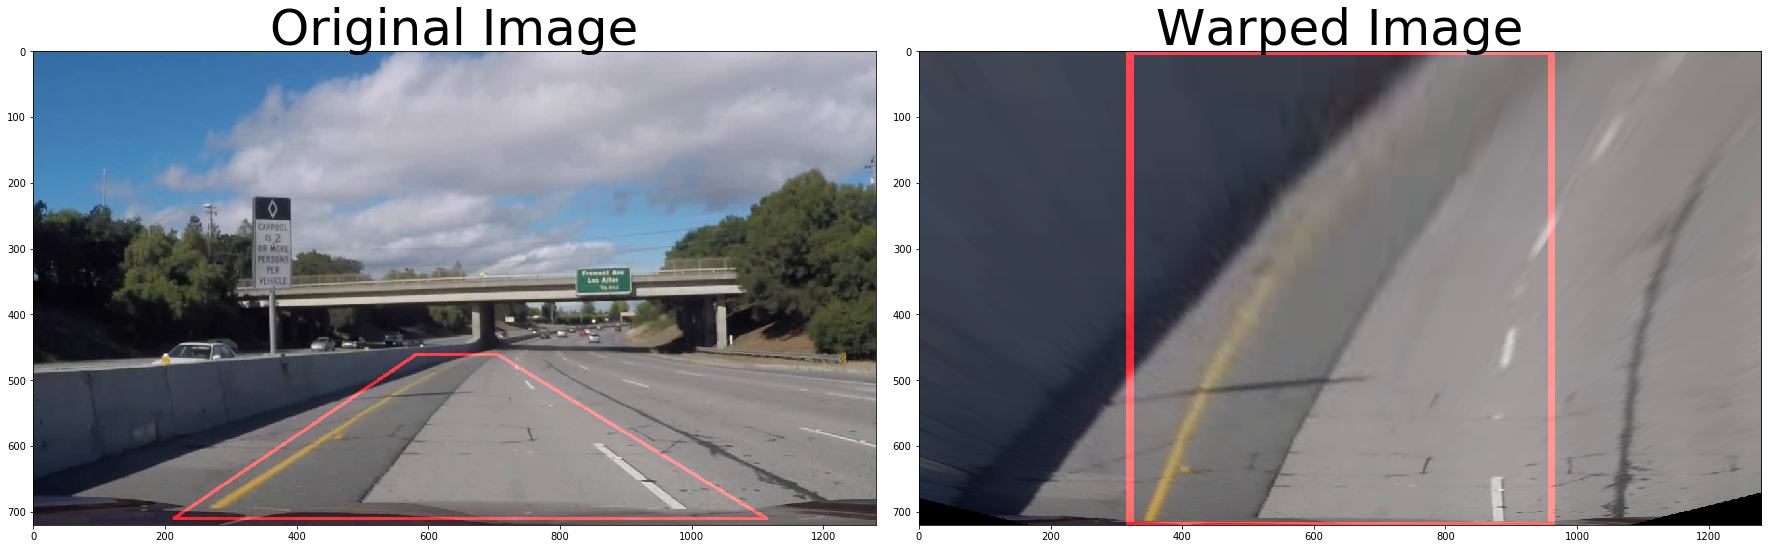

In [8]:
img= mpimg.imread('./test_images/challenge01.jpg')

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
img_size = (gray.shape[1],gray.shape[0])

src = np.float32(
        [[(img_size[0] / 2) - 58, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 0), img_size[1]-10],
        [(img_size[0] * 5 / 6) + 48, img_size[1]-10],
        [(img_size[0] / 2 + 64), img_size[1] / 2 + 100]])
dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])

window_img = np.zeros_like(img_undistroted)
cv2.polylines(window_img, np.int_([src]), 1, (255, 0, 0), 3)
result = cv2.addWeighted(img, 1.0, window_img, 0.8, 0.)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(result)
ax1.set_title('Original Image', fontsize=50)

warped, _= warpPerspective_from_img(img)
window_img = np.zeros_like(warped)
cv2.polylines(window_img, np.int_([dst]), 1, (255, 0, 0), 10)
result = cv2.addWeighted(warped, 1.0, window_img, 0.8, 0.)

ax2.imshow(result)
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [9]:
# Fit the line for the 1st time or no good fit can be carried over from last frame

def new_fit(image):
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    
    # Set the width of the windows +/- margin
    margin = 80

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    line_pixels = [leftx, lefty, rightx, righty]
    
    return left_fit, right_fit, line_pixels

In [10]:
# Fit the line if good fit is detected in last frame

def carry_over_fit(image, left_fit_prev, right_fit_prev):
    # Set the width of the windows +/- margin
    margin = 80

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    win_x_left = left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2]
    win_x_right = right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2]
    
    left_lane_inds = ((nonzerox > (win_x_left - margin)) & (nonzerox < (win_x_left + margin))) 
    right_lane_inds = ((nonzerox > (win_x_right - margin)) & (nonzerox < (win_x_right + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    line_pixels = [leftx, lefty, rightx, righty]
    
    return left_fit, right_fit, line_pixels

In [11]:
# Put the process warp image back to original image

def warpPerspective_to_img(image, image_original, left_fit, right_fit, line_pixels, Minv):

    if left_fit is None or right_fit is None:
        return image_original
    
    # Create an image to draw the lines on
    else:
        out_img = np.dstack((image, image, image))*255
        window_img = np.zeros_like(out_img)

        window_img[line_pixels[1], line_pixels[0]] = [255, 0, 0]
        window_img[line_pixels[3], line_pixels[2]] = [0, 0, 255]

        ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([pts]), (0,255, 0))

        newwarp = cv2.warpPerspective(window_img, Minv, (image_original.shape[1], image_original.shape[0]))
        return cv2.addWeighted(image_original, 0.8, newwarp, 0.3, 0)

In [12]:
# Calculation of curvature and offset based on fit coefficients 

def cal_curverad_offset(image, left_fit, right_fit, line_pixels):
    left_curverad, right_curverad, offset = (0, 0, 0)
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    if len(line_pixels[1]) != 0 and len(line_pixels[2]) != 0 and len(line_pixels[2]) != 0 and len(line_pixels[3]) != 0:
        left_fit_cr = np.polyfit(line_pixels[1]*ym_per_pix, line_pixels[0]*xm_per_pix, 2)
        right_fit_cr = np.polyfit(line_pixels[3]*ym_per_pix, line_pixels[2]*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    if left_fit is not None and right_fit is not None:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        offset = ((right_fitx[-1] + left_fitx[-1])/2 - image.shape[1]/2)*xm_per_pix
    
    return left_curverad, right_curverad, offset

In [13]:
# Plot the curvature and offset on final processed image

def plot_text(image, left_curverad, right_curverad, offset):
    text = 'Radius of Curvature = {}(m)'.format(int((left_curverad + right_curverad)/2))
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image,text,(50,60), font, 1.5,(255,255,255),2,cv2.LINE_AA)
    
    if offset > 0:
        offset_side = 'left'
    else:
        offset_side = 'right'
        
    text = 'Vehicle is {:0.2f}m {} of the center'.format(abs(offset), offset_side)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image,text,(50,120), font, 1.5,(255,255,255),2,cv2.LINE_AA)

In [14]:
# Plot the fit lines in processing with monitoring 

def plot_fit(image, left_fit, right_fit, color = (255,255,0)):
    if left_fit is None and right_fit is None:
        return image

    else:
        new_image = np.copy(image)
        ploty = np.linspace(0, image.shape[0]-1, image.shape[0])
        if left_fit is not None:            
            plotx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
            cv2.polylines(new_image, np.int32([pts]), isClosed=False, color=color, thickness=8)
        if right_fit is not None:            
            plotx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
            cv2.polylines(new_image, np.int32([pts]), isClosed=False, color=color, thickness=8)
    return new_image

In [15]:
# Define a class to receive the characteristics of each line detection

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False     
        
        #polynomial coefficients of the last n iterations
        self.recent_fits = []
        
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
    def add_fit(self, fit):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.recent_fits) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                #self.px_count = np.count_nonzero(inds)
                self.recent_fits.append(fit)
                if len(self.recent_fits) > 5:
                    # throw out old fits, keep newest n
                    self.recent_fits = self.recent_fits[len(self.recent_fits)-5:]
                self.best_fit = np.average(self.recent_fits, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.recent_fits) > 0:
                # throw out oldest fit
                self.recent_fits = self.recent_fits[1:len(self.recent_fits)]
            if len(self.recent_fits) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.recent_fits, axis=0)
        


In [16]:
# Image processing pipeline

def process_image(image):

    #image = np.fliplr(image)
    img_undistroted = undistroted(image)
    warped, Minv = warpPerspective_from_img(img_undistroted)
    image_from_combined_binary = combined_binary(warped)
    
    if not left_history.detected or not right_history.detected:
        left_fit, right_fit, line_pixels = new_fit(image_from_combined_binary)
    else:
        left_fit, right_fit, line_pixels = carry_over_fit(image_from_combined_binary, left_history.best_fit, right_history.best_fit)
    
    left_history.add_fit(left_fit)
    right_history.add_fit(right_fit)
    
    left_curverad, right_curverad, offset = cal_curverad_offset(image_from_combined_binary, left_history.best_fit, right_history.best_fit, line_pixels)
    #left_curverad, right_curverad, offset = cal_curverad_offset(image_from_combined_binary, left_fit, right_fit, line_pixels)
    
    result = warpPerspective_to_img(image_from_combined_binary, img_undistroted, left_history.best_fit, right_history.best_fit, line_pixels, Minv)
    #result = warpPerspective_to_img(image_from_combined_binary, img_undistroted, left_fit, right_fit, line_pixels, Minv)
    
    plot_text(result, left_curverad, right_curverad, offset)
    
    return result

In [17]:
# Image processing pipeline with monitoring binary and line fitting

def process_diag(image):
    
    #image = np.fliplr(image)
    img_undistroted = undistroted(image)
    warped, Minv = warpPerspective_from_img(img_undistroted)
    image_from_combined_binary = combined_binary(warped)   
    
    if not left_history.detected or not right_history.detected:
        left_fit, right_fit, line_pixels = new_fit(image_from_combined_binary)
    else:
        left_fit, right_fit, line_pixels = carry_over_fit(image_from_combined_binary, left_history.best_fit, right_history.best_fit)
    
    left_history.add_fit(left_fit)
    right_history.add_fit(right_fit)
    
    left_curverad, right_curverad, offset = cal_curverad_offset(image_from_combined_binary, left_history.best_fit, right_history.best_fit, line_pixels)
    #left_curverad, right_curverad, offset = cal_curverad_offset(image_from_combined_binary, left_fit, right_fit, line_pixels)
    
    result = warpPerspective_to_img(image_from_combined_binary, img_undistroted, left_history.best_fit, right_history.best_fit, line_pixels, Minv)
    #result = warpPerspective_to_img(image_from_combined_binary, img_undistroted, left_fit, right_fit, line_pixels, Minv)
    
    plot_text(result, left_curverad, right_curverad, offset)
    
    diag_img = np.zeros((360,1280,3), dtype=np.uint8)
    diag_img[0:360,0:640,:] = cv2.resize(result,(640,360))
    
    combined_binary_stack = np.dstack((image_from_combined_binary*255, image_from_combined_binary*255, image_from_combined_binary*255))
    #diag_img[0:360,640:1280, :] = cv2.resize(combined_binary_stack,(640,360))
    
    plot_fit_diag1 = plot_fit(combined_binary_stack, left_fit, right_fit)
    plot_fit_diag = plot_fit(plot_fit_diag1, left_history.best_fit, right_history.best_fit, color = (0, 255, 0))
    diag_img[0:360,640:1280,:] = cv2.resize(plot_fit_diag,(640,360))
    
    
    return diag_img
    #return plot_fit_diag

In [18]:
# Processing on a video

left_history = Line()
right_history = Line()

#cap = cv2.VideoCapture('./project_video.mp4')
cap = cv2.VideoCapture('./challenge_video.mp4')
#cap = cv2.VideoCapture('./harder_challenge_video.mp4')

while(cap.isOpened()):
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    #processed_img = cv2.cvtColor(process_image(frame), cv2.COLOR_RGB2BGR)
    processed_img = cv2.cvtColor(process_diag(frame), cv2.COLOR_RGB2BGR)
    cv2.imshow('frame', processed_img)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

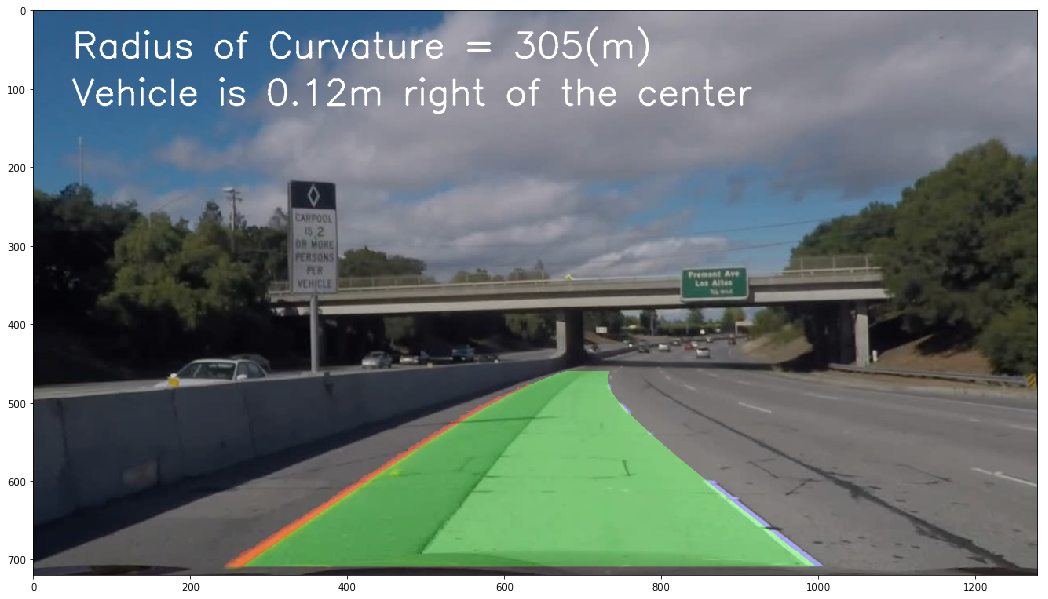

In [19]:
# Processing on a image

left_history = Line()
right_history = Line()

#img = mpimg.imread('./test_images/straight_lines2.jpg')
#img = mpimg.imread('./test_images/test1.jpg')
img = mpimg.imread('./test_images/challenge01.jpg')
#img = mpimg.imread('./challeng_video_frames/frame90.jpg')

result = process_image(img)
#result = process_diag(img)

fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(result)

## Create Video

In [20]:
from moviepy.editor import VideoFileClip

In [20]:
left_history = Line()
right_history = Line()

file_output = './output_harder_challenge_video_diag.mp4'

clip1 = VideoFileClip('./harder_challenge_video.mp4')
white_clip = clip1.fl_image(process_diag) #NOTE: this function expects color images!!
%time white_clip.write_videofile(file_output, audio=False)

[MoviePy] >>>> Building video ./output_harder_challenge_video_diag.mp4
[MoviePy] Writing video ./output_harder_challenge_video_diag.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [06:52<00:00,  3.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_harder_challenge_video_diag.mp4 

Wall time: 6min 53s
